In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchsummary import summary

# <u>Convolutional Neural Networks</u>

Convolutional neural networks (CNNs) are neural network architectures that use predominantly *convolutional layers*. These are essentially parametric sliding windows that filter the input to extract local features. While, in linear layers, a different weight is applied to each element of the input, in convolutional layers the same set of weights is applied to different parts of the input. This allows to extract features that are *position-invariant*. <br>
For instance, if we are processing an image, convolutional layers may find particulars like eyes or hands, regardless of where they are located in the picture. Here is an illustration of how a filter of a 2D convolutional layer works:
https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif <br>
**For deeper insights on them, check the .pdf document of the second tutorial of the course.**

Let's seed up and initialize some hyperparameters:

In [ ]:
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)

device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

batch_size = 16
lr = 5e-4
adam_betas = (0.9, 0.9)
n_epochs = 6

We'll use the MNIST dataset:

In [ ]:
datapath = 'data'

# load the MNIST dataset:
data_train = MNIST(
    root = datapath,
    train = True, # this we'll use for training the model
    transform = ToTensor(),
    download=True
)
data_test = MNIST(
    root = datapath,
    train = False, # and this for testing
    transform = ToTensor(),
    download=True
)

# initialize train set and test set loaders:
train_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

test_loader = DataLoader(
    data_test,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

### <u>Output Dimensionality</u>

Differently from linear layers, which can have any size you want, you need to be careful when defining your convolutional layers, since the way the output dimensionality is determined is not as straightforward. <br>
More specifically, the formulae to determine the output height and width ($H_{out}$, $W_{out}$) of a channel are as follows: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html <br>
However, in this notebook, we'll simplify things by assuming that the kernel, padding, and strides are equal along all dimensions:

\begin{equation*}
H_{out} = \left\lfloor \dfrac{H_{in} + (2\times \text{padding}[0]) - \text{dilation[0]} \times (\text{kernel_size[0]} - 1) - 1} {\text{stride[0]} } + 1 \right\rfloor
\end{equation*}

\begin{equation*}
W_{out} = \left\lfloor \dfrac{W_{in} + (2\times \text{padding}[0]) - \text{dilation[1]} \times (\text{kernel_size[1]} - 1) - 1} {\text{stride[1]} } + 1 \right\rfloor
\end{equation*}

Let's try with the first layer: we have a $28\times 28$ input image (so the same calculation holds for both height and width), a kernel of size $3$, no padding, no stride, no dilation:

\begin{equation*}
\dfrac{28 + (2 \times 1) - 1 \times (3 - 1) - 1}{1} + 1 = 28 + 2 - 2 - 1 + 1 = 28,
\end{equation*}

so, the output dimension should be the same as the input dimension. What about the third layer? There, we have a $7 \times 7$ images, a kernel of size $2$, no padding, and a dilation of $2$:

\begin{equation*}
\dfrac{7 + (2 \times 1) - 2 \times (2-1) - 1}{1} + 1 = 7 + 2 - 2 - 1 + 1 = 7,
\end{equation*}

so, the dimensionality does not change here as well.

Regarding the calculation of trainable parameters, you can check the documentation or the .pdf document that's been provided to you at the second tutorial.

### <u>Simple 2D CNN Example for MNIST Classification</u>

This is a simple CNN architecture that we'll use to classify MNIST digits:

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes=10):
        super(SimpleCNN, self).__init__()

        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            dilation=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            dilation=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=2,
            stride=1,
            padding=1,
            dilation=2
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # non-parametric, same object can be used

        self.fc1 = nn.Linear(
            in_features=64*3*3,
            out_features=32
        )
        self.fc2 = nn.Linear(
            in_features=32,
            out_features=self.n_classes
        )

    def forward(self, x):          # dimension analysis:
        x = F.relu(self.conv1(x))  # 1x28x28  --> 16x28x28
        x = self.pool(x)           # 16x28x28 --> 16x14x14
        x = F.relu(self.conv2(x))  # 16x14x14 --> 32x14x14
        x = self.pool(x)           # 32x14x14 --> 32x7x7
        x = F.relu(self.conv3(x))  # 32x7x7   --> 64x7x7
        x = self.pool(x)           # 64x7x7   --> 64x3x3
        x = x.view(-1, 64 * 3 * 3) # 64x3x3   --> 64*3*3
        x = F.relu(self.fc1(x))    # 64*3*3   --> 32
        x = self.fc2(x)            # 32       --> 10
        return x

Confirm that the data loaders work, and visualize a sample:

input.shape  = torch.Size([16, 1, 28, 28])
labels.shape = torch.Size([16])



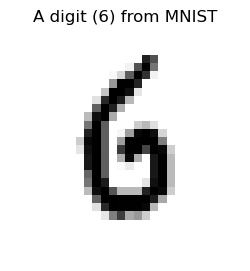

In [ ]:
x1_batch, y1_batch = next(iter(train_loader))
x1_batch, y1_batch = x1_batch.to(device), y1_batch.to(device)
print(f"input.shape  = {x1_batch.shape}\nlabels.shape = {y1_batch.shape}\n")

plt.figure(figsize=(3,3))
plt.imshow(x1_batch[-1, 0].cpu(), cmap='binary')
plt.axis('off')
plt.title(f"A digit ({y1_batch[-1]}) from MNIST")
plt.show()
plt.close()

Create a model, confirm that the forward pass works, print output shape and architecture:

In [ ]:
model = SimpleCNN(n_classes=10).to(device)
out = model(x1_batch)
print(f"output.shape = {out.shape}")
_ = summary(model=model, input_data=x1_batch[0].shape, device=device)

output.shape = torch.Size([16, 10])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [-1, 16, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [-1, 32, 7, 7]            --
├─Conv2d: 1-5                            [-1, 64, 7, 7]            8,256
├─MaxPool2d: 1-6                         [-1, 64, 3, 3]            --
├─Linear: 1-7                            [-1, 32]                  18,464
├─Linear: 1-8                            [-1, 10]                  330
Total params: 31,850
Trainable params: 31,850
Non-trainable params: 0
Total mult-adds (M): 1.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.12
Estimated Total Size (MB): 0.29


As in Tutorial 2, we'll design a function to measure the accuracy of our model:

In [ ]:
def model_accuracy(data_loader):

    n_total = 0
    n_correct = 0

    for x_batch_, y_batch_ in data_loader:
        x_batch_ = x_batch_.to(device)
        y_batch_ = y_batch_.to(device)
        logits_batch_ = model(x_batch_)  # model's output scores
        n_total += len(y_batch_)
        n_correct += sum(logits_batch_.argmax(axis=-1) == y_batch_).item()
    return n_correct / n_total

acc_train = model_accuracy(train_loader)
print(f"Accuracies before training:\n Train = {acc_train:.4f}\n Test  = {model_accuracy(test_loader):.4f}")

Accuracies before training:
 Train = 0.0987
 Test  = 0.0980


Define loss function and optimizer:

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = tc.optim.Adam(params=model.parameters(), lr=lr, betas=adam_betas)

Training loop:

In [ ]:
accuracies_train = []

for epoch in range(n_epochs):

    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits_batch = model(x_batch)
        loss_batch = loss_fn(logits_batch, y_batch)
        loss_batch.backward()
        optimizer.step()

    # evaluate the model at the end of each epoch
    with tc.no_grad():
        acc_train = model_accuracy(train_loader)
        print(f"Epoch {epoch+1:03d} | train set accuracy = {acc_train:.4f}")
        accuracies_train.append(acc_train)

Epoch 001 | train set accuracy = 0.9516
Epoch 002 | train set accuracy = 0.9805
Epoch 003 | train set accuracy = 0.9842
Epoch 004 | train set accuracy = 0.9862
Epoch 005 | train set accuracy = 0.9917
Epoch 006 | train set accuracy = 0.9935


Results:

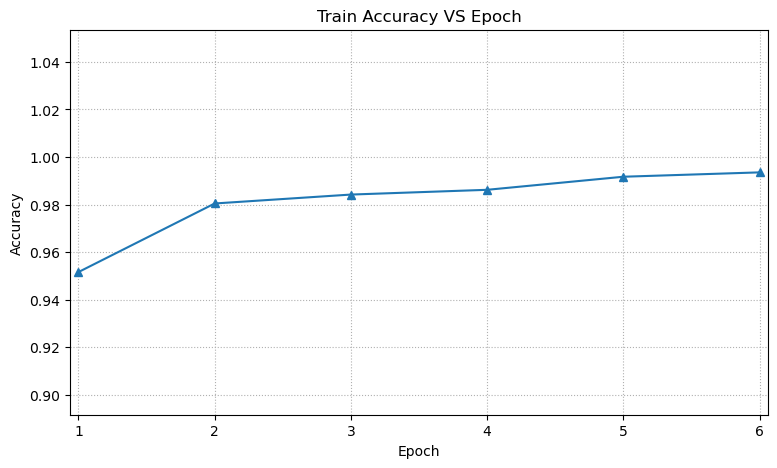

In [ ]:
epoch_ax = np.arange(start=1, stop=n_epochs+1, step=1)
plt.figure(figsize=(9,5))
plt.plot(epoch_ax, accuracies_train, '^-')
plt.grid(linestyle=':')
e = 0.06
plt.ylim([min(accuracies_train)-e, max(accuracies_train)+e])
plt.xlim([1-e, n_epochs+e])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy VS Epoch")
plt.show()
plt.close()

In [ ]:
print(f"Accuracies after training:\n Train = {model_accuracy(train_loader):.4f}\n Test  = {model_accuracy(test_loader):.4f}")

Accuracies after training:
 Train = 0.9935
 Test  = 0.9903


Compared with our previous notebook with the MLP classifier, with our CNN now we achieved:
 - (i) 40% less trainable parameters
 - (ii) slightly better accuracy (3%)
 - (iii) less training time required per epoch
 - (iv) half the epochs required for convergence

Finally, a standard way to save the model's weights is:

In [ ]:
tc.save(model.state_dict(), f"saved_models/CNN.pt")

# <u>Homework (optional)</u>

-How sensitive is this model to initialization?

-Include a validation set as we did in the previous notebook, and use it to find better hyperparameters for the network.

-Try to reduce the number of trainable parameters, compromising as little accuracy as you can.

-See if this model correctly classifies digits generated from a GMM like the one of our previous tutorial.